## Summary
Based on NBA career statistics from all Basketball Hall of Fame inductees, a predictive model is used to calculate the probability of hall of fame induction for all active and recently-retired players.

## Introduction
Since 1959, the Naismith Memorial Basketball Hall of Fame has inducted almost 400 coaches, players, referees, contributors, and teams. It honors individuals who have shown exceptional skill at basketball, all-time great coaches, referees, and other major contributors to the sport (broadcasters, journalists, etc.). 

Several people have been inducted multiple times, either as players/coaches or as coaches/contributors. A players does have to play in the NBA to be inducted, as career achievements in college, WNBA, international teams, and other platforms are considered. For a player to be eligible on the ballot, he or she must be fully retired for at least three years. They can also become inducted as a part of a historically-significant team, such as the 1992 US men's Olympic basketball team - widely regarded as the greatest team ever assembled in any sports.

To analyze which current and recently-retired players will become inducted into the hall of fame in the future, I created various models based on almost 60 years of previous data.

## Data & Methods
Based on the data web scraped from [Basketball Reference](https://www.basketball-reference.com/), I created a database of all historical ABA/NBA players since 1947 who played at least one game. For these players, I retrieved the following stats:

- name: full name of player, first name and last name
- active_from: year started playing for the NBA
- active_to: last year playing for the NBA (2018 is still active)
- career_length: seasons played in league (disregards if retired during)
- birth_date: datetime variable, date of birth
- position: five positions classification - most common approach in modern ear
- trad_position: three positions classification - traditional approach of describing positions
- ppg: float variable, total points per game
- trb: float variable, total rebounds per game
- ast: float variable, total assists per game
- per: float variable, [player efficiency rating](https://www.basketball-reference.com/about/per.html)
- ws: float variable, [win shares](https://www.basketball-reference.com/about/ws.html)
- height_inches: float variable, height measured in inches
- weight: float variable, weight measured in pounds
- shooting hand: prefered shooting hand
- hof: 0 or 1, inducted into Naismith Memorial Basketball Hall of Fame as player
    * 0 if inducted as coach, contributor, etc.
- college: college basketball programs of participation
- hs_name: name of high school attended
- hs_city: city of high school location
- hs_state: state or country (if foreign player) of high school
- url: player page in www.basketball-reference.com

Using all the counting statistics, such as career per-game statstics and advanced stats, I created four models to predict a player's hall of fame induction probability. 

With these inputs and outputs, I created four models:
 - Logistic regression
 - Decision tree and random forest classifier
 - Naive Bayes classifier
 - Support vector regression (SVM)

The models were trained and tested on hall of fame data from 1947-2015, and then made predictions for current players and players retired since 2015.

## Limitations

**Careers outside of NBA**: Players who achieved college stardom or international success, but did not have the same level of success in the NBA, are just as eligible for the hall of fame. For example, Arvydas Sabonis was inducted in 2011 for his legendary career in the European stage, despite only playing seven seasons in the NBA and averaging 12 points-per-game. 


**Active players**: We are using data gathered up to 2018 season, meaning we are disregarding future career achievements. This will be disadvantageous for promising young players who are still finding their rhythm in the league. Essentially, we are asking the question "If this player retired today, will he be elected into the hall of fame?".

**Narrative**: Players who are considered pioneers of the game are more likely to be inducted (such as Yao Ming), while those who have 'damaged the integrity of the game of basketball' are less likely to be inducted. For example, Gilbert Arenas averaged 20.7 points-per-game and received multiple accolades throughout his career. While he is not a sure hall-of-famer based on his stats alone, he is unlikely to be ever nominated due to a handgun violations incident during the 2009-2010 season. 

**Limited Data**: The data (for now) does not all important player achievements, such as all-star selection, all-NBA team selection,  championships (team success), and other awards (MVP, Rookie of the year, all-defense team, etc.)

## Importing and loading data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set_style('whitegrid')
from bs4 import BeautifulSoup, SoupStrainer
import sys, string, requests, datetime, time
%matplotlib inline

Preview table:

In [34]:
players = pd.read_csv('Tables/players.csv') # this csv file is taken from web scraped data from Baskeball-Reference
players.head()

,name,active_from,active_to,career_length,birth_date,position,trad_position,ppg,trb,ast,...,ws,height_inches,weight,shooting_hand,hof,college,hs_name,hs_city,hs_state,url
0,Alaa Abdelnaby,1991,1995,4,1968-06-24,Power Forward,Forward,5.7,3.3,0.3,...,4.8,82.0,240.0,Right,0.0,Duke University,Bloomfield,Bloomfield,New Jersey,/players/a/abdelal01.html
1,Zaid Abdul-Aziz,1969,1978,9,1946-04-07,Power Forward,Forward,9.0,8.0,1.2,...,17.5,81.0,235.0,Right,0.0,Iowa State University,John Jay,Brooklyn,New York,/players/a/abdulza01.html
2,Kareem Abdul-Jabbar,1970,1989,19,1947-04-16,Center,Center,24.6,11.2,3.6,...,273.4,86.0,225.0,Right,1.0,"University of California, Los Angeles",Power Memorial,New York,New York,/players/a/abdulka01.html
3,Mahmoud Abdul-Rauf,1991,2001,10,1969-03-09,Point Guard,Guard,14.6,1.9,3.5,...,25.2,73.0,162.0,Right,0.0,Louisiana State University,Gulfport,Gulfport,Mississippi,/players/a/abdulma02.html
4,Tariq Abdul-Wahad,1998,2003,5,1974-11-03,Shooting Guard,Guard,7.8,3.3,1.1,...,3.5,78.0,223.0,Right,0.0,"University of Michigan, San Jose State University",Lycee Aristide Briand,Evreux,France,/players/a/abdulta01.html


In [3]:
#hof_not_eligible = players[players['active_to'] > 2015]
players_hof = players[players['hof'] == 1.0]
players_not_hof = players[players['hof'] == 0]

## Data visualization

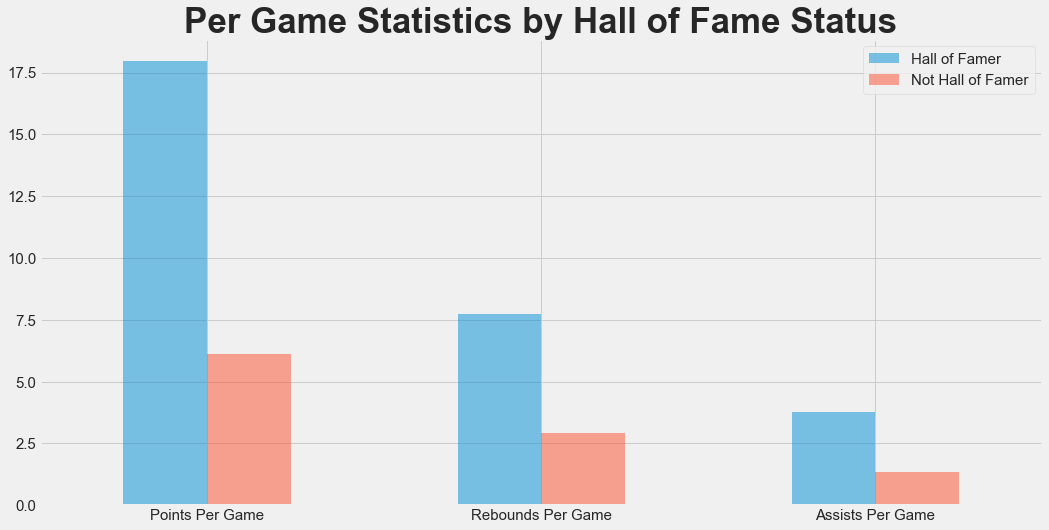

In [19]:
plt.style.use('fivethirtyeight')

sort_by_hof = players.groupby('hof')['ppg', 'trb', 'ast'] # statistics grouped by hof status
sort_by_hof = sort_by_hof.mean().transpose()  # average stats, transposed for graphing purposes
sort_by_hof = sort_by_hof.rename({'ppg': 'Points Per Game', 
                                  'trb': 'Rebounds Per Game', 
                                  'ast': 'Assists Per Game'},
                                   axis='index')
sort_by_hof = sort_by_hof.rename({1: 'Hall of Famer', 
                                  0: 'Not Hall of Famer'}, 
                                  axis='columns')
sort_by_hof = sort_by_hof[sort_by_hof.columns[::-1]] # reverse column order
sort_by_hof.plot(kind='bar', figsize=(16,8), alpha=0.5, rot=0)

plt.legend(prop={'size':15}, frameon=True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.title('Per Game Statistics by Hall of Fame Status', fontsize=35, fontweight="bold")


plt.savefig('all-graphs/hof_stats.png')

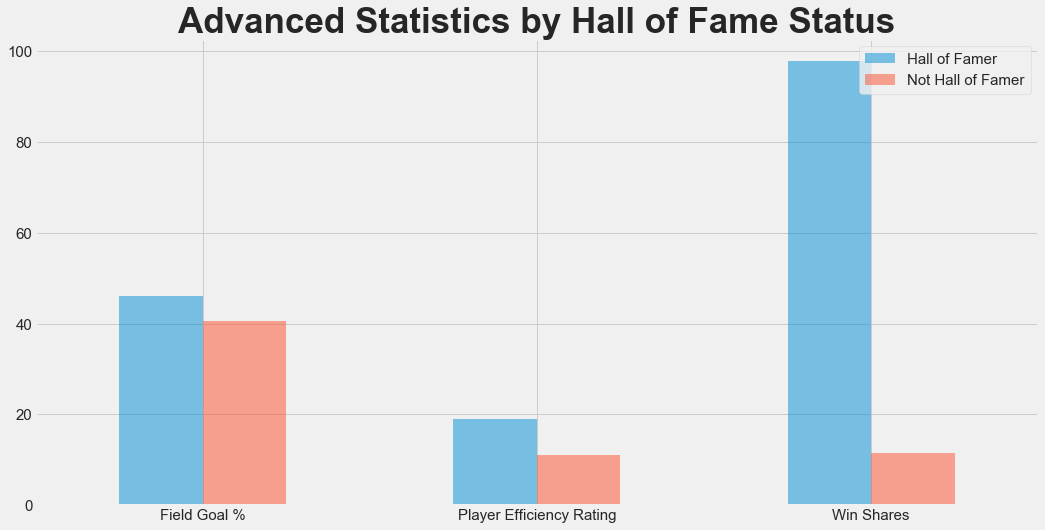

In [20]:
plt.style.use('fivethirtyeight')

sort_by_hof = players.groupby('hof')['fgp', 'per', 'ws'] # statistics grouped by hof status
sort_by_hof = sort_by_hof.mean().transpose()  # average stats, transposed for graphing purposes
sort_by_hof = sort_by_hof.rename({'fgp': 'Field Goal %',
                                  'per': 'Player Efficiency Rating',
                                  'ws': 'Win Shares'},
                                   axis='index')
sort_by_hof = sort_by_hof.rename({1: 'Hall of Famer', 
                                  0: 'Not Hall of Famer'}, 
                                  axis='columns')
sort_by_hof = sort_by_hof[sort_by_hof.columns[::-1]] # reverse column order
sort_by_hof.plot(kind='bar', figsize=(16,8), alpha=0.5, rot=0)

plt.legend(prop={'size':15}, frameon=True, loc=1)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.title('Advanced Statistics by Hall of Fame Status', fontsize=35, fontweight="bold")


plt.savefig('all-graphs/hof_adv_stats.png')

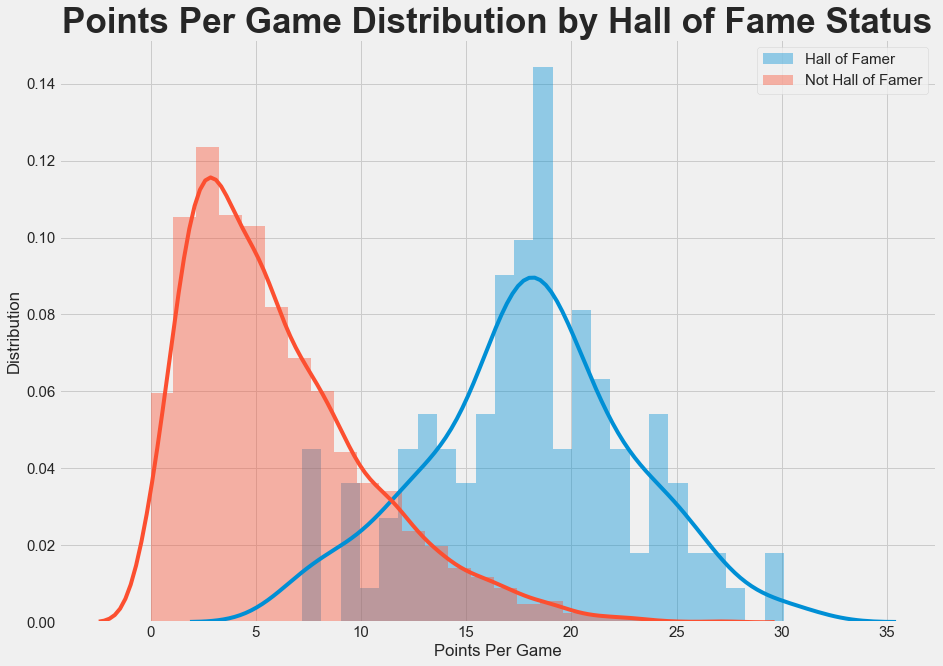

In [21]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(14,10))
sns.distplot(players_hof['ppg'], bins=25, label='Hall of Famer')
sns.distplot(players_not_hof['ppg'].fillna(0), bins=25, label='Not Hall of Famer')

plt.legend(loc=1, frameon=True, prop={'size': 15})
plt.xlabel("Points Per Game")
plt.ylabel("Distribution")
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('Points Per Game Distribution by Hall of Fame Status', fontsize=35, fontweight="bold")

plt.savefig('all-graphs/hof_ppg.png')

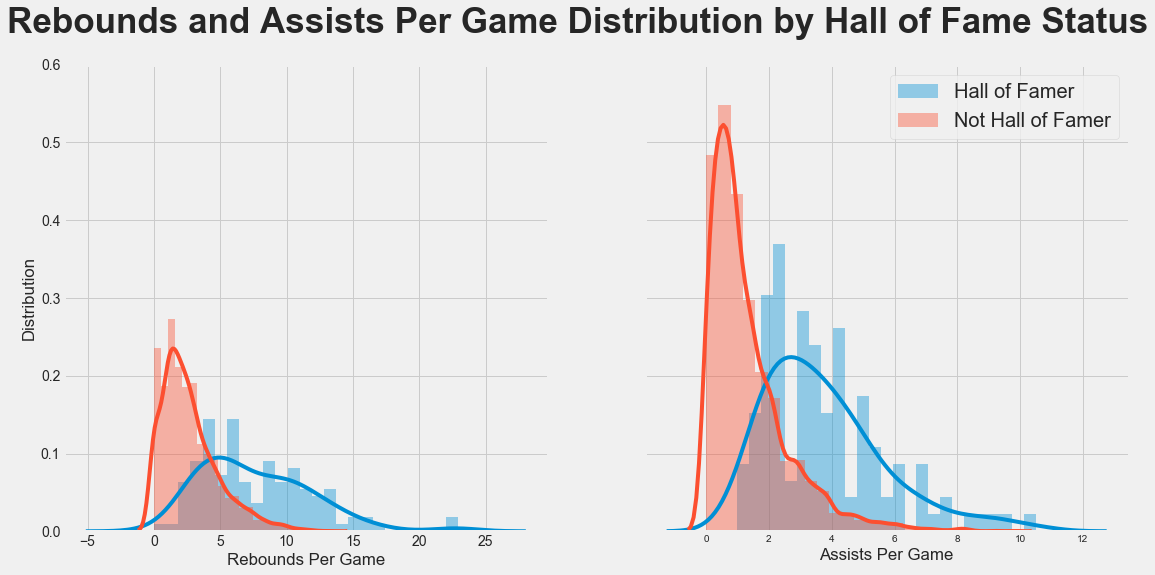

In [22]:
plt.style.use('fivethirtyeight')

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(17,8))

sns.distplot(players_hof['trb'].fillna(0), bins=25, label='Hall of Famer', ax=ax1)
sns.distplot(players_not_hof['trb'].fillna(0), bins=25, label='Not Hall of Famer', ax=ax1)
ax1.set(xlabel='Rebounds Per Game', ylabel='Distribution')
plt.xticks(fontsize=27)

sns.distplot(players_hof['ast'].fillna(0), bins=25, label='Hall of Famer', ax=ax2)
sns.distplot(players_not_hof['ast'].fillna(0), bins=25, label='Not Hall of Famer', ax=ax2)
ax2.set(xlabel='Assists Per Game')

plt.legend(loc=1, frameon=True, prop={'size': 20})
plt.ylim(0, 0.6)
plt.xticks(fontsize=10)

from pylab import *
fig = gcf()
fig.suptitle('Rebounds and Assists Per Game Distribution by Hall of Fame Status', fontsize=35, fontweight="bold")

plt.savefig('all-graphs/hof_trb_ast.png')

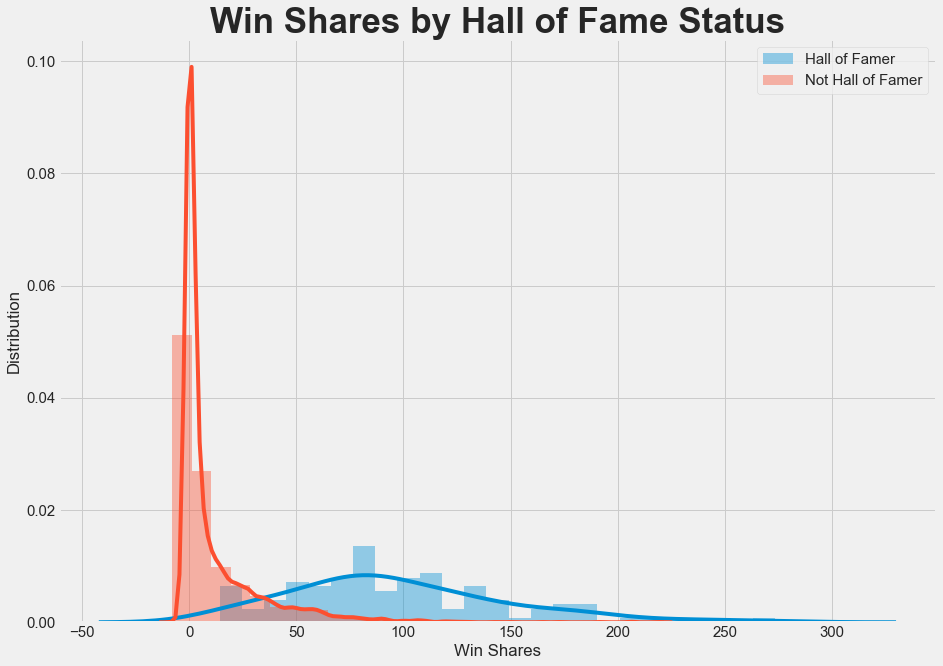

In [23]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(14,10))
sns.distplot(players_hof['ws'], bins=25, label='Hall of Famer')
sns.distplot(players_not_hof['ws'].fillna(0), bins=25, label='Not Hall of Famer')

plt.legend(loc=1, frameon=True, prop={'size': 15})
plt.xlabel("Win Shares")
plt.ylabel("Distribution")
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('Win Shares by Hall of Fame Status', fontsize=35, fontweight="bold")

plt.savefig('all-graphs/hof_ws.png')

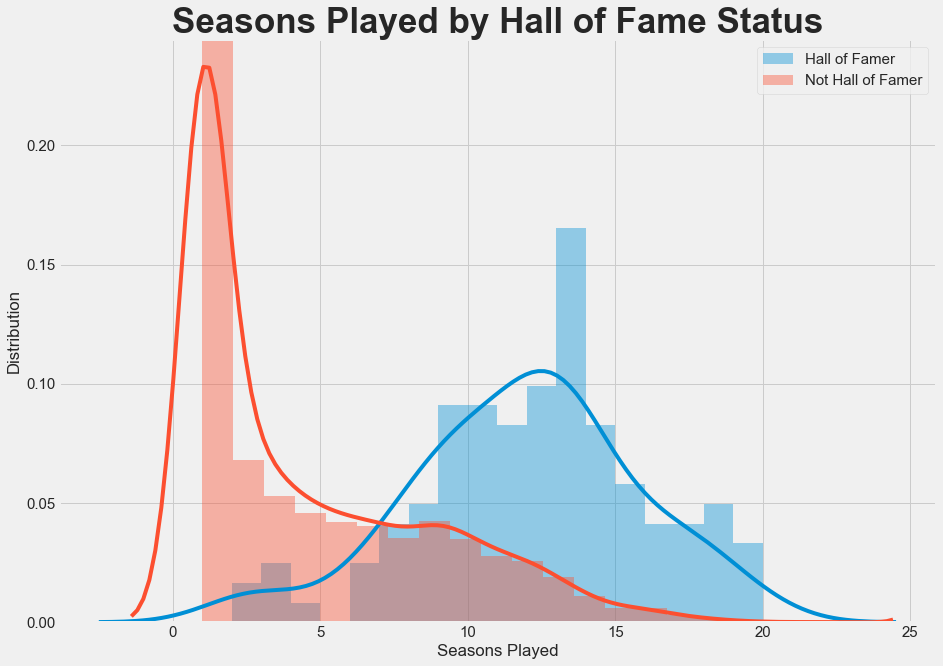

In [24]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(14,10))
sns.distplot(players_hof['career_length'], bins=18, label='Hall of Famer')
sns.distplot(players_not_hof['career_length'].fillna(0), bins=20, label='Not Hall of Famer')

plt.legend(loc=1, frameon=True, prop={'size': 15})
plt.xlabel("Seasons Played")
plt.ylabel("Distribution")
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('Seasons Played by Hall of Fame Status', fontsize=35, fontweight="bold")

plt.savefig('all-graphs/hof_seasons_played.png')

## Model data for Machine Learning regression

Active players are incidated by '2018' in the active_to column (this data was web scraped between 2018 adn 2019 season). 

All active palyers also have 0 under hall-of-fame status, because to be considered for induction a player must be fully retired for at least three full seasons. This will skew the regression model, since it will interpretate that no current player, regardless of their career achievements, were deserving of the hall of fame status. Someone like LeBron James and Dirk Nowitzki are first-ballot future hall of famers, but as of nwo the model interprets that they did not receive the nomination.

To get a more accurate interpretation of the hall of fame statuses, the data needs to be narrowed down to retired players who were eligible to be considered. All active players and anyone who retired after 2015 were excluded.

In [39]:
hof_eligible = players[players['active_to'] < 2015].dropna()

hof_eligible = hof_eligible[['career_length', 'ppg', 'trb', 'ast', 'per', 'ws', 'hof']]
hof_eligible.head()

,career_length,ppg,trb,ast,per,ws,hof
0,4,5.7,3.3,0.3,13.0,4.8,0.0
1,9,9.0,8.0,1.2,15.1,17.5,0.0
2,19,24.6,11.2,3.6,24.6,273.4,1.0
3,10,14.6,1.9,3.5,15.4,25.2,0.0
4,5,7.8,3.3,1.1,11.4,3.5,0.0


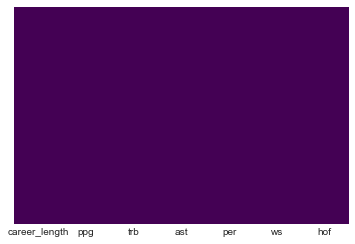

In [6]:
sns.heatmap(hof_eligible.isnull(), yticklabels=False, cbar=False, cmap='viridis')

We see that there are no null values in our dataframe - if there were, it would be highlighted yellow in the above heatmap. We will proceed with using this dataframe to run supervised machine learning algorithms.

## Predicting hall of fame status

In [7]:
print("Correlation between career length and HOF: {}".format(hof_eligible['career_length'].corr(hof_eligible['hof'])))
print("Correlation between PPG and HOF: {}".format(hof_eligible['ppg'].corr(hof_eligible['hof'])))
print("Correlation between TRB and HOF: {}".format(hof_eligible['trb'].corr(hof_eligible['hof'])))
print("Correlation between AST and HOF: {}".format(hof_eligible['ast'].corr(hof_eligible['hof'])))
print("Correlation between PER and HOF: {}".format(hof_eligible['per'].corr(hof_eligible['per'])))
print("Correlation between WS and HOF: {}".format(hof_eligible['ws'].corr(hof_eligible['ws'])))

Correlation between career length and HOF: 0.3280495662008085
Correlation between PPG and HOF: 0.4845889282872929
Correlation between TRB and HOF: 0.40351326295279066
Correlation between AST and HOF: 0.34074647367188027
Correlation between PER and HOF: 1.0
Correlation between WS and HOF: 1.0


In [41]:
from sklearn.model_selection import train_test_split

X = hof_eligible[['career_length', 'ppg', 'trb', 'ast', 'per', 'ws']]
y = hof_eligible['hof']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

<font color='blue'>Logistic Regression</font>

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
predictions = logmodel.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))
print('\n')
print('accuracy Score: ', accuracy_score(y_test, predictions)) 

             precision    recall  f1-score   support

        0.0       0.97      1.00      0.99       831
        1.0       0.92      0.51      0.66        45

avg / total       0.97      0.97      0.97       876



[[829   2]
 [ 22  23]]


accuracy Score:  0.9726027397260274


<font color='blue'>Decision Tree Classifier</font>

In [49]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))
print('\n')
print('accuracy Score: ', accuracy_score(y_test, predictions))   

             precision    recall  f1-score   support

        0.0       0.97      0.98      0.98       831
        1.0       0.63      0.49      0.55        45

avg / total       0.95      0.96      0.96       876



[[818  13]
 [ 23  22]]


accuracy Score:  0.958904109589041


<font color='blue'>Random Forest Classifier</font>

In [50]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))
print('\n')
print('accuracy Score: ', accuracy_score(y_test, predictions))

             precision    recall  f1-score   support

        0.0       0.97      0.98      0.98       831
        1.0       0.63      0.49      0.55        45

avg / total       0.95      0.96      0.96       876



[[818  13]
 [ 23  22]]


accuracy Score:  0.958904109589041


<font color='blue'>Naive Bayes Classifier</font>

In [51]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))
print('\n')
print('accuracy Score: ', accuracy_score(y_test, predictions))  

             precision    recall  f1-score   support

        0.0       0.99      0.94      0.96       831
        1.0       0.43      0.89      0.58        45

avg / total       0.96      0.93      0.94       876



[[778  53]
 [  5  40]]


accuracy Score:  0.9337899543378996


<font color='blue'>Support Vector Machine Classifier</font>

In [52]:
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train,y_train)
predictions = svc_model.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))
print('\n')
print('accuracy Score: ', accuracy_score(y_test, predictions))  

             precision    recall  f1-score   support

        0.0       0.95      1.00      0.97       831
        1.0       0.00      0.00      0.00        45

avg / total       0.90      0.95      0.92       876



[[831   0]
 [ 45   0]]


accuracy Score:  0.9486301369863014


C:\Users\sonye\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Using the model on current players to predict hall of fame status

Now we will look at players who either recently retired or currently playing in the league. We will try to predict, based on the models we ran above, if they will be inducted into the hall of fame based on their career average statistics. One important note is that since we are including career length as a factor, this model only focuses on on career achievements up to this point; it does not take account for a player's remaining seasons left in the league.

Table of all active/recently-retired players who are not yet eligible for hall of fame:

In [53]:
hof_not_eligible = players[players['active_to'] > 2015][['name', 'career_length', 'ppg', 'trb', 'ast', 'per', 'ws']]
hof_not_eligible = hof_not_eligible.sort_values(by='ppg', ascending=False)
hof_not_eligible = hof_not_eligible.dropna()
hof_not_eligible.head(10)

,name,career_length,ppg,trb,ast,per,ws
1963,LeBron James,14,27.2,7.4,7.2,27.7,219.4
1088,Kevin Durant,10,27.1,7.1,3.9,25.3,130.2
529,Kobe Bryant,19,25.0,5.2,4.7,22.9,172.7
107,Carmelo Anthony,14,24.1,6.5,3.0,20.3,100.7
902,Anthony Davis,5,23.4,10.3,1.9,27.1,62.5
869,Stephen Curry,8,23.1,4.4,6.8,23.8,93.3
2422,Damian Lillard,5,23.1,4.1,6.2,21.0,58.2
4319,Russell Westbrook,9,23.0,6.6,8.2,23.9,90.1
1631,James Harden,8,23.0,5.1,6.1,23.7,106.7
4193,Dwyane Wade,14,22.5,4.7,5.5,23.9,118.3


As a test, we can look at Kobe Bryant's hall of fame probability with logistic regression model we ran using the retired players data

In [54]:
KB = hof_not_eligible[hof_not_eligible['name'] == 'Kobe Bryant'][['career_length', 'ppg', 'trb', 'ast', 'per', 'ws']]
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
predictions = logmodel.predict_proba(KB)
print("Probability: {}".format(predictions[0][1]))

Probability: 0.9887246794727226


Now, we will calculate the future hall of fame status and probability for all active and recently-retired players using logistic regression

In [56]:
hof_list_log = []
for player in hof_not_eligible['name']:
    player = hof_not_eligible[hof_not_eligible['name'] == player][['career_length', 'ppg', 'trb', 'ast', 'per', 'ws']]
    predictions = logmodel.predict(player)
    hof_list_log.append(int(predictions))
hof_df_log = pd.DataFrame(hof_list_log)

hof_list_log_proba = []
for player in hof_not_eligible['name']:
    player = hof_not_eligible[hof_not_eligible['name'] == player][['career_length', 'ppg', 'trb', 'ast', 'per', 'ws']]
    predictions = logmodel.predict_proba(player)
    hof_list_log_proba.append(predictions[0][1])
hof_df_log_proba = pd.DataFrame(hof_list_log_proba)

In [98]:
"""
hof_list_dtree = []
for player in hof_not_eligible['name']:
    player = hof_not_eligible[hof_not_eligible['name'] == player][['career_length', 'ppg', 'trb', 'ast', 'per', 'ws']]
    predictions = dtree.predict(player)
    hof_list_dtree.append(int(predictions))
hof_df_dtree = pd.DataFrame(hof_list_dtree)

hof_list_dtree_proba = []
for player in hof_not_eligible['name']:
    player = hof_not_eligible[hof_not_eligible['name'] == player][['career_length', 'ppg', 'trb', 'ast', 'per', 'ws']]
    predictions = dtree.predict_proba(player)
    hof_list_dtree_proba.append(predictions[0][1])
hof_df_dtree_proba = pd.DataFrame(hof_list_dtree_proba)
"""

In [57]:
hof_not_eligible['hof_pred_log'] = pd.DataFrame(hof_df_log).values
hof_not_eligible['hof_pred_log_proba'] = pd.DataFrame(hof_df_log_proba).values
#hof_not_eligible['hof_pred_dtree'] = pd.DataFrame(hof_df_dtree).values
#hof_not_eligible['hof_pred_dtree_proba'] = pd.DataFrame(hof_df_dtree_proba).values
hof_not_eligible = hof_not_eligible.sort_values(by='hof_pred_log_proba', ascending=False)
hof_not_eligible.head()

,name,career_length,ppg,trb,ast,per,ws,hof_pred_log,hof_pred_log_proba
1963,LeBron James,14,27.2,7.4,7.2,27.7,219.4,1,0.999986
1081,Tim Duncan,18,19.0,10.8,3.0,24.2,206.4,1,0.999216
3152,Chris Paul,12,18.7,4.5,9.8,25.6,164.8,1,0.998631
3008,Dirk Nowitzki,19,21.2,7.7,2.5,22.6,206.1,1,0.998316
1373,Kevin Garnett,20,17.8,10.0,3.7,22.7,191.4,1,0.994402


In [58]:
hof_not_eligible.to_csv('Tables/hof_not_eligible.csv', index=False)

In [59]:
hof_not_eligible = pd.read_csv('Tables/hof_not_eligible.csv')

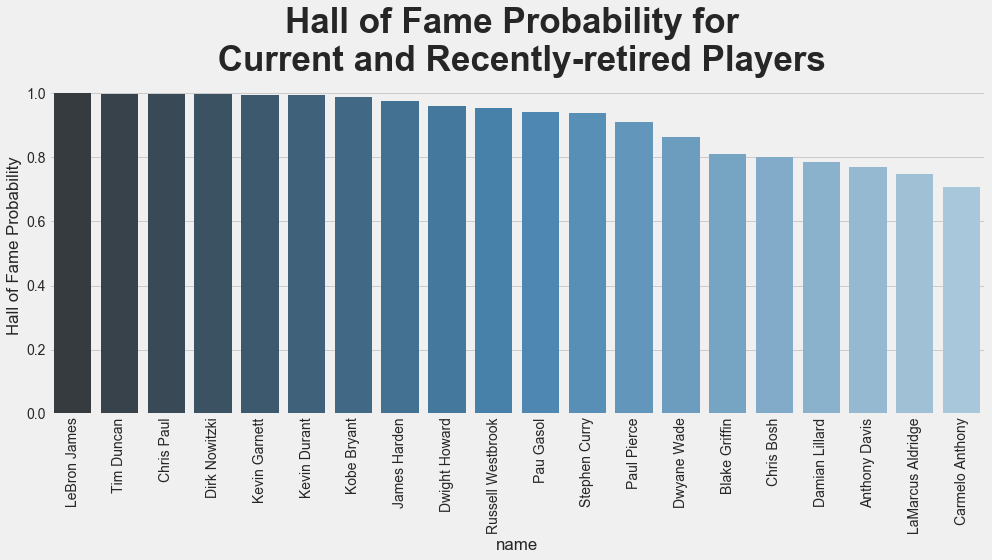

In [101]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(14,8))

#plt.figure(figsize=(16,12))

ax = sns.barplot(x='name', y='hof_pred_log_proba', data=hof_not_eligible[:20], palette="Blues_d")
plt.title('Hall of Fame Probability for \n Current and Recently-retired Players', fontsize=35, fontweight='bold')
ax.set_xticklabels(hof_not_eligible['name'],rotation=90)
ax.set(xlabel='', ylabel='Hall of Fame Probability')


plt.tight_layout()

plt.savefig('all-graphs/hof_pred.png')

Here we see that ppg and ws are highly correlated to hall of fame probability. Most people will agree that all players listed above will be in the hall of them after they retire.

In [104]:
hof_not_eligible.sort_values(['ppg', 'hof_pred_log_proba'], ascending=[False, False]).head(10)

,name,career_length,ppg,trb,ast,per,ws,hof_pred_log,hof_pred_log_proba
0,LeBron James,14,27.2,7.4,7.2,27.7,219.4,1,0.999986
5,Kevin Durant,10,27.1,7.1,3.9,25.3,130.2,1,0.993883
6,Kobe Bryant,19,25.0,5.2,4.7,22.9,172.7,1,0.988725
19,Carmelo Anthony,14,24.1,6.5,3.0,20.3,100.7,1,0.706483
17,Anthony Davis,5,23.4,10.3,1.9,27.1,62.5,1,0.770886
11,Stephen Curry,8,23.1,4.4,6.8,23.8,93.3,1,0.938722
16,Damian Lillard,5,23.1,4.1,6.2,21.0,58.2,1,0.784332
7,James Harden,8,23.0,5.1,6.1,23.7,106.7,1,0.976304
9,Russell Westbrook,9,23.0,6.6,8.2,23.9,90.1,1,0.953089
13,Dwyane Wade,14,22.5,4.7,5.5,23.9,118.3,1,0.863284


Now, let's look at veteran players who are not likely to be in the hall of fame. These plaeyrs have been in the league for more than a decade, but the model predicted that they will not be inducted based on the available player data.

We will define veterans as players who are in the top 10% of number of years played in the league. This is 12 years, so we will only include players who played at least 12 years in the league.

In [105]:
veterans = hof_not_eligible[hof_not_eligible['career_length'] >= hof_not_eligible['career_length'].quantile(0.90)]
veterans = veterans[veterans['hof_pred_log'] == 0]
veterans.head()

,name,career_length,ppg,trb,ast,per,ws,hof_pred_log,hof_pred_log_proba
29,Tony Parker,16,15.8,2.8,5.7,18.3,110.4,0,0.384071
32,Amar'e Stoudemire,13,18.9,7.8,1.2,21.8,92.5,0,0.345558
34,Vince Carter,19,17.7,4.5,3.3,19.1,123.5,0,0.328114
36,Andre Iguodala,13,12.6,5.2,4.4,15.8,92.1,0,0.321115
44,Andre Miller,16,12.5,3.7,6.5,17.4,100.8,0,0.228461


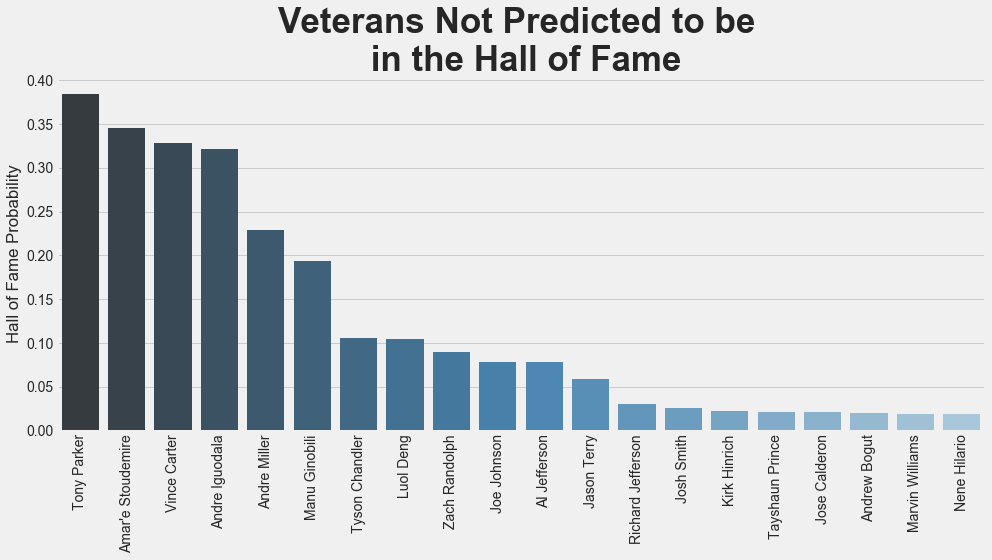

In [103]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(14,8))

#plt.figure(figsize=(16,12))

ax = sns.barplot(x='name', y='hof_pred_log_proba', data=veterans[:20], palette="Blues_d")
plt.title('Veterans Not Predicted to be \n in the Hall of Fame', fontsize=35, fontweight='bold')
ax.set_xticklabels(veterans['name'],rotation=90)
ax.set(xlabel='', ylabel='Hall of Fame Probability')

plt.tight_layout()

plt.savefig('all-graphs/not_hof_pred.png')

Here, we see players who have played more than 12 years in the league who are not predicted to be in the hall of fame.

Here we can see the limitation of the predictive model. Anyone who is familiar with the NBA knows that players like Tony Parker and Manu Ginobili are definite locks for the hall of fame. This is because Parker and Ginobili have team success, having played in the same team for most of their careers and winning 4 championships. They also had successful international careers;  Parker played for the French national team and won multiple FIBA Player of the Year awards, while Manu was on the Argentinian team that won the gold medal at 2004 Olympic games over the stacked USA team. 

On the other hand, Vince Carter, while not winning any championships, is arguably the greatest dunker ever, one of the most popular players ever, one of the highest all-star vote getters for years, and put Canada on the map for NBA teams. He is also known for his longevity, re-inventing himself as a 6th man and as roleplayer towards the end of his career.

Excluding those three players (and possibly Stoudemire), most will agree that these veterans are not likely to be in the hall of fame. 

## Conclusion

The model predicts tha LeBron James - based on current achievements - has the highest likelyhood of becoming inducted into the hall of fame. Recently-retired players like Tim Duncan, Kevin Garnett, and Kobe Bryant - all likely to be in the hall of fame class of 2021 - will be inducted within a few years. We also saw the model's limitations, since it does not take account for international career, team success, awards, cultural impact, etc. However, the model is mostly accurate in predicting which active and recently-retired players will be inducted.